<a id="top"></a>

# 02_ENCODE_OFFLINE — Codificación offline a H5 (formato **v2**)

Convierte los `splits` CSV (`train/val/test`) ya preparados en **archivos H5** con codificación temporal. Es la vía recomendada cuando el preset activa `data.use_offline_spikes: true` y `data.encode_runtime: false`, porque **acelera la E/S** y fija exactamente los mismos eventos para todos los métodos.

**Qué hace este notebook**
- Localiza el fichero de tareas según el preset: usa `tasks_balanced.json` si `prep.use_balanced_tasks: true` y **existe**; si no, cae a `tasks.json` (se avisa en consola).
- Para cada `run` y `split`, lee el CSV correspondiente y aplica la **codificación temporal** (`rate | latency | raw`) con los parámetros del preset (`T`, `gain`, `img_w/img_h`, `to_gray`).
- Escribe H5 con **formato v2** auto-descriptivo y nomenclatura estable (incluye `encoder`, `T`, `gain`, `gray|rgb`, `W×H`).

**Formato H5 v2 (resumen)**
- Atributos: `version=2`, `encoder`, `T`, `gain`, `size_wh=[W,H]`, `to_gray`, `channels`
- Datasets:
  - `/spikes`:  
    - gris → `(N, T, H, W)`  
    - RGB → `(N, T, C, H, W)`  
    - tipo: `rate/raw → uint8`, `latency → float32`
  - `/steering`: `(N,)`
  - `/filenames`: `(N,)` (rutas relativas para trazabilidad)

---

<a id="toc"></a>
## 🧭 Índice
1. [Configuración de codificación (parámetros y rutas)](#sec-01)
2. [Helper multi-PRESET (opcional)](#sec-02)
3. [Generación de H5 para RUNS × SPLITS](#sec-03)
4. [Inspección QC del H5 (formato v2)](#sec-04)


<a id="sec-01"></a>
## 1) Configuración de codificación (parámetros y rutas)

**Objetivo:** dejar listos los parámetros de codificación temporal y las rutas base.
- Lee el **preset** (`fast|std|accurate`) desde `configs/presets.yaml`.
- Fija: `ENCODER`, `T`, `GAIN`, `SIZE=(W,H)`, `TO_GRAY`, `SEED`.
- Detecta el fichero de tareas a usar (preferente `tasks_balanced.json` si procede).
- Construye `RUNS` y `SPLITS = ["train","val","test"]`.

[↑ Volver al índice](#top)

In [ ]:
from pathlib import Path
import sys, json
import pandas as pd  # opcional

ROOT = Path.cwd().parents[0] if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.config import load_preset
from src.prep.encode_offline import encode_csv_to_h5

PRESET = "accurate"  # fast | std | accurate
CFG = load_preset(ROOT / "configs" / "presets.yaml", PRESET)

ENCODER = str(CFG["data"]["encoder"])
T       = int(CFG["data"]["T"])
GAIN    = float(CFG["data"]["gain"])
SIZE    = (int(CFG["model"]["img_w"]), int(CFG["model"]["img_h"]))  # (W, H)
TO_GRAY = bool(CFG["model"]["to_gray"])
SEED    = int(CFG["data"]["seed"])

RAW_ROOT  = ROOT / "data" / "raw" / "udacity"
PROC_ROOT = ROOT / "data" / "processed"

USE_BALANCED = bool(CFG.get("prep", {}).get("use_balanced_tasks", False))
tasks_balanced_name = (CFG.get("prep", {}).get("tasks_balanced_file_name") or "tasks_balanced.json")
tasks_plain_name    = (CFG.get("prep", {}).get("tasks_file_name") or "tasks.json")

candidate = PROC_ROOT / (tasks_balanced_name if USE_BALANCED else tasks_plain_name)
TASKS_PATH = candidate if candidate.exists() else (PROC_ROOT / tasks_plain_name)

if candidate.exists():
    print("Usando tasks:", candidate.name)
else:
    print(f"[WARN] No existe {candidate.name}; usando {tasks_plain_name} en su lugar.")

TASKS  = json.loads(TASKS_PATH.read_text(encoding="utf-8"))
RUNS   = TASKS["tasks_order"]
SPLITS = ["train", "val", "test"]

print(f"[PRESET={PRESET}] encoder={ENCODER} T={T} gain={GAIN} | size={SIZE} gray={TO_GRAY} | seed={SEED}")
print("RUNS:", RUNS)


Usando tasks: tasks_balanced.json
[PRESET=std] encoder=rate T=18 gain=0.7 | size=(200, 66) gray=False | seed=42
RUNS: ['circuito1', 'circuito2']


<a id="sec-02"></a>
## 2) Helper multi-PRESET (opcional)

Permite **codificar varios PRESETs** en la misma ejecución sin duplicar lógica.  
Rellena `EXTRA_PRESETS` con nombres válidos del YAML.

[↑ Volver al índice](#top)

In [2]:
EXTRA_PRESETS = []  # p. ej.: ["fast", "accurate"]

def _encode_for_preset(preset_name: str) -> dict:
    """Carga un preset y devuelve parámetros autocontenidos para codificar H5."""
    CFGp = load_preset(ROOT / "configs" / "presets.yaml", preset_name)
    ENCODERp = str(CFGp["data"]["encoder"])
    Tp = int(CFGp["data"]["T"])
    GAINp = float(CFGp["data"]["gain"])
    SIZEp = (int(CFGp["model"]["img_w"]), int(CFGp["model"]["img_h"]))
    TO_GRAYp = bool(CFGp["model"]["to_gray"])
    SEEDp = int(CFGp["data"]["seed"])

    USE_BALANCEDp = bool(CFGp.get("prep", {}).get("use_balanced_tasks", False))
    tasks_balanced_name_p = (CFGp.get("prep", {}).get("tasks_balanced_file_name") or "tasks_balanced.json")
    tasks_plain_name_p    = (CFGp.get("prep", {}).get("tasks_file_name") or "tasks.json")
    candidate_p = PROC_ROOT / (tasks_balanced_name_p if USE_BALANCEDp else tasks_plain_name_p)
    TASKS_PATHp = candidate_p if candidate_p.exists() else (PROC_ROOT / tasks_plain_name_p)
    TASKSp = json.loads(TASKS_PATHp.read_text(encoding="utf-8"))

    return dict(
        ENCODER=ENCODERp, T=Tp, GAIN=GAINp, SIZE=SIZEp, TO_GRAY=TO_GRAYp, SEED=SEEDp,
        TASKS=TASKSp, TASKS_PATH=TASKS_PATHp, RUNS=TASKSp["tasks_order"],
        SPLITS=["train","val","test"], USE_BALANCED=USE_BALANCEDp
    )


<a id="sec-03"></a>
## 3) Generación de H5 para RUNS × SPLITS

**Qué hace:**
- Recorre cada `run × split`, comprueba existencia del CSV y llama a `encode_csv_to_h5(...)`.
- Escribe un H5 por salida con **nomenclatura determinista**:  
  `<split>_<encoder>_T<T>_gain<g>_<gray|rgb>_<W>x<H>.h5`
- Guarda en `SAMPLE_OUTS` el primer H5 de cada PRESET para inspección rápida.

**Idempotencia y limpieza:**
- No hace falta borrar H5 antiguos al cambiar parámetros: el **nombre de salida cambia** (no se pisan).
- Si quieres ahorrar espacio, elimina manualmente H5 viejos que no uses.

[↑ Volver al índice](#top)

In [3]:
SAMPLE_OUTS = []
SAMPLE_OUT  = None

PRESETS_TO_RUN = [PRESET] + list(EXTRA_PRESETS)

for P in PRESETS_TO_RUN:
    info = _encode_for_preset(P)
    ENCODER = info["ENCODER"]; T = info["T"]; GAIN = info["GAIN"]
    SIZE = info["SIZE"]; TO_GRAY = info["TO_GRAY"]; SEED = info["SEED"]
    RUNS = info["RUNS"]; SPLITS = info["SPLITS"]

    # Cargamos el preset para leer crop_top / crop_bottom del bloque model
    CFG_P   = load_preset(ROOT / "configs" / "presets.yaml", P)
    MODEL_P = CFG_P["model"]
    CROP_TOP    = int(MODEL_P.get("crop_top", 0) or 0)
    CROP_BOTTOM = int(MODEL_P.get("crop_bottom", 0) or 0)

    print(f"\n=== PRESET={P} | encoder={ENCODER} T={T} gain={GAIN} size={SIZE} "
          f"gray={TO_GRAY} seed={SEED} ct={CROP_TOP} cb={CROP_BOTTOM} ===")
    print("Usando tasks:", info["TASKS_PATH"].name, "| balanced:", info["USE_BALANCED"])
    print("RUNS:", RUNS)

    color_tag = "gray" if TO_GRAY else "rgb"
    gain_tag  = GAIN if ENCODER == "rate" else 0
    W, H = SIZE

    # sufijo opcional para el crop
    crop_tag = ""
    if CROP_TOP or CROP_BOTTOM:
        crop_tag = f"_ct{CROP_TOP}_cb{CROP_BOTTOM}"

    SAMPLE_OUT = None
    for run in RUNS:
        base   = RAW_ROOT / run
        outdir = PROC_ROOT / run
        outdir.mkdir(parents=True, exist_ok=True)
        assert base.exists(), f"No existe carpeta de imágenes: {base}"

        paths = info["TASKS"]["splits"][run]
        for split in SPLITS:
            csv = Path(paths[split])
            if not csv.is_absolute():
                csv = ROOT / csv
            assert csv.exists(), f"No existe CSV: {csv}"

            out = outdir / f"{split}_{ENCODER}_T{T}_gain{gain_tag}_{color_tag}_{W}x{H}{crop_tag}.h5"

            encode_csv_to_h5(
                csv_df_or_path=csv,
                base_dir=base,
                out_path=out,
                encoder=ENCODER,
                T=T,
                gain=GAIN,
                size_wh=(W, H),
                to_gray=TO_GRAY,
                crop_top=CROP_TOP,
                crop_bottom=CROP_BOTTOM,
                seed=SEED,
            )
            print("OK:", out)
            if SAMPLE_OUT is None:
                SAMPLE_OUT = out

    SAMPLE_OUTS.append((P, SAMPLE_OUT))

print("\nHecho.")
for P, out in SAMPLE_OUTS:
    print(f"Ejemplo de salida [{P}]:", out)



=== PRESET=std | encoder=rate T=18 gain=0.7 size=(200, 66) gray=False seed=42 ct=60 cb=20 ===
Usando tasks: tasks_balanced.json | balanced: True
RUNS: ['circuito1', 'circuito2']
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T18_gain0.7_rgb_200x66_ct60_cb20.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/val_rate_T18_gain0.7_rgb_200x66_ct60_cb20.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/test_rate_T18_gain0.7_rgb_200x66_ct60_cb20.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/train_rate_T18_gain0.7_rgb_200x66_ct60_cb20.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/val_rate_T18_gain0.7_rgb_200x66_ct60_cb20.h5
OK: /home/cesar/proyectos/TFM_SNN/data/processed/circuito2/test_rate_T18_gain0.7_rgb_200x66_ct60_cb20.h5

Hecho.
Ejemplo de salida [std]: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T18_gain0.7_rgb_200x66_ct60_cb20.h5


<a id="sec-04"></a>
## 4) Inspección QC del H5 (formato v2)

**Qué verifica esta celda:**
- Abre `SAMPLE_OUT` y muestra **atributos** (comprueba `version=2`, `encoder`, `T`, `gain`, `size_wh`, `to_gray`, `channels`).
- Lista **datasets** y sus **formas/tipos**.
- Calcula y dibuja una **proyección acumulada** del primer ejemplo:
  - gris: sum sobre `T` → `H×W`
  - RGB: sum sobre `T` y `C` → `H×W`

**Interpretación:**  
En `rate/raw` (binario, `uint8`), la proyección refleja **densidad de actividad** por píxel.  
En `latency` (`float32`), revisa que los valores sigan la convención del codificador.

[↑ Volver al índice](#toc)


Mostrando: /home/cesar/proyectos/TFM_SNN/data/processed/circuito1/train_rate_T18_gain0.7_rgb_200x66_ct60_cb20.h5
Atributos:
 - T: 18
 - channels: 3
 - crop_bottom: 20
 - crop_top: 60
 - encoder: rate
 - gain: 0.7
 - size_wh: [200  66]
 - to_gray: 0
 - version: 2
Datasets: ['filenames', 'spikes', 'steering']
spikes: (460012, 18, 3, 66, 200) uint8 | steering: (460012,) float32


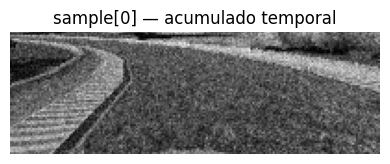

In [4]:
from pathlib import Path
import h5py, numpy as np, matplotlib.pyplot as plt

SAMPLE_OUT = SAMPLE_OUTS[0][1] if (not globals().get("SAMPLE_OUT") and SAMPLE_OUTS) else globals().get("SAMPLE_OUT")
if SAMPLE_OUT is None:
    raise RuntimeError("Genera al menos un H5 en la celda 3 (SAMPLE_OUT).")

print("Mostrando:", SAMPLE_OUT)

def _proj_img(x):
    # (T,H,W) -> acumula T; (T,C,H,W) -> acumula T y C
    if x.ndim == 2:  return x
    if x.ndim == 3:  return x.sum(axis=0)
    if x.ndim == 4:  return x.sum(axis=(0,1))
    raise ValueError(x.shape)

with h5py.File(SAMPLE_OUT, "r") as h5:
    print("Atributos:")
    for k, v in h5.attrs.items():
        print(f" - {k}: {v}")
    print("Datasets:", list(h5.keys()))
    X = h5["spikes"]; y = h5["steering"]
    print("spikes:", X.shape, X.dtype, "| steering:", y.shape, y.dtype)
    x0 = X[0]
    acc = _proj_img(x0)

plt.figure(figsize=(4, 3))
plt.imshow(acc, cmap="gray")
plt.title("sample[0] — acumulado temporal")
plt.axis("off")
plt.tight_layout()
plt.show(); plt.close()
